In [548]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()

In [549]:
#Read data
csv_file = 'CPI.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   年       393 non-null    int64  
 1   月       393 non-null    int64  
 2   CPI     393 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 9.3 KB


In [550]:
df['Date'] = df['年'].astype(str) + '-' + (df['月'].astype(int)).astype(str) + '-01'
df.head()

,年,月,CPI,Date
0,1990,1,40.0,1990-1-01
1,1990,2,40.3,1990-2-01
2,1990,3,40.8,1990-3-01
3,1990,4,41.3,1990-4-01
4,1990,5,41.7,1990-5-01


In [551]:
#Data cleaning
df_clean = df.loc[:,['Date','CPI']]
df_clean.rename(columns={'Date':'date','CPI':'cpi'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df_clean.head()

,date,cpi
0,1990-01-01,40.0
1,1990-02-01,40.3
2,1990-03-01,40.8
3,1990-04-01,41.3
4,1990-05-01,41.7


In [552]:
#Subseting data
df_clean.set_index('date',inplace=True)
start_date = pd.to_datetime('2000-01-01')
df_clean = df_clean[start_date:]
df_clean.head()

,cpi
date,
2000-01-01,71.5
2000-02-01,71.4
2000-03-01,71.2
2000-04-01,71.2
2000-05-01,71.1


In [553]:
#Useful functions
#Print Graph
def plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear):
    plt.figure(figsize=(10,4))
    plt.plot(dataframe[column])
    plt.title(plottitle, fontsize=20)
    plt.ylabel(plotylabel, fontsize=16) 
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] < 0.05):
        print('It is stationary')
    else:
        print('It is non-stationary')

#The additive model is useful when the seasonal variation is relatively constant over time.
#The multiplicative model is useful when the seasonal variation increases over time.
def seasonDecomposer(dataframe, column, models='additive', periods=1):
    plt.rcParams.update({'figure.figsize':(10,10)})
    seasonal_decompose(dataframe[column], model=models, period=periods).plot().suptitle(f'\n{models} decompose', fontsize=12)

#Combine all funtions
def plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1):
    ADFtest(dataframe, column)
    plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear)
    # “ywm” : Yule-Walker without adjustment. Default.
    # “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
    #alpha  : 0.05 = 95% confidence interval
    plot_acf(df_clean.cpi,  alpha=.05, lags=30)
    plot_pacf(df_clean.cpi,  alpha=.05, method='ywm')   
    seasonDecomposer(dataframe, column, models, periods)

def allStationarity(dataframe,column):
    dataframe['after_log'] = np.log(df_clean[column])
    dataframe['difference_1'] = dataframe[column] - dataframe[column].shift(1)
    dataframe['difference_2'] = dataframe[column] - 2*dataframe[column].shift(1) + dataframe[column].shift(2)
    dataframe['log_difference_1'] = dataframe['after_log'] - dataframe['after_log'].shift(1)
    dataframe['log_difference_2'] = dataframe['after_log'] - 2*dataframe['after_log'].shift(1) + dataframe['after_log'].shift(2)
    dataframe.dropna(inplace=True)
    for data in [column,'after_log','difference_1','difference_2','log_difference_1','log_difference_2']:
        adfuller_result = adfuller(dataframe[data].values, autolag='AIC')
        if (adfuller_result[1] < 0.05):
            print(data + ' : stationary')
        else:
            print(data + ' : non-stationary')

ADF statistic: 0.526115366115142
p-value      : 0.9856456057022294
Critical values:
  1%,  -3.4558530692911504
Critical values:
  5%,  -2.872764881778665
Critical values:
  10%,  -2.572751643088207
It is non-stationary


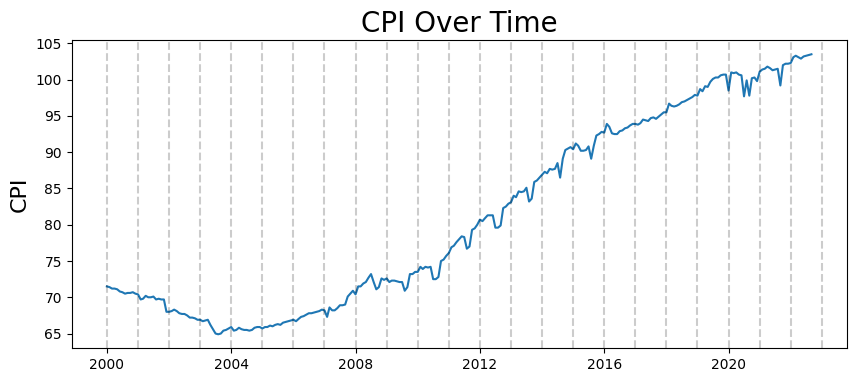

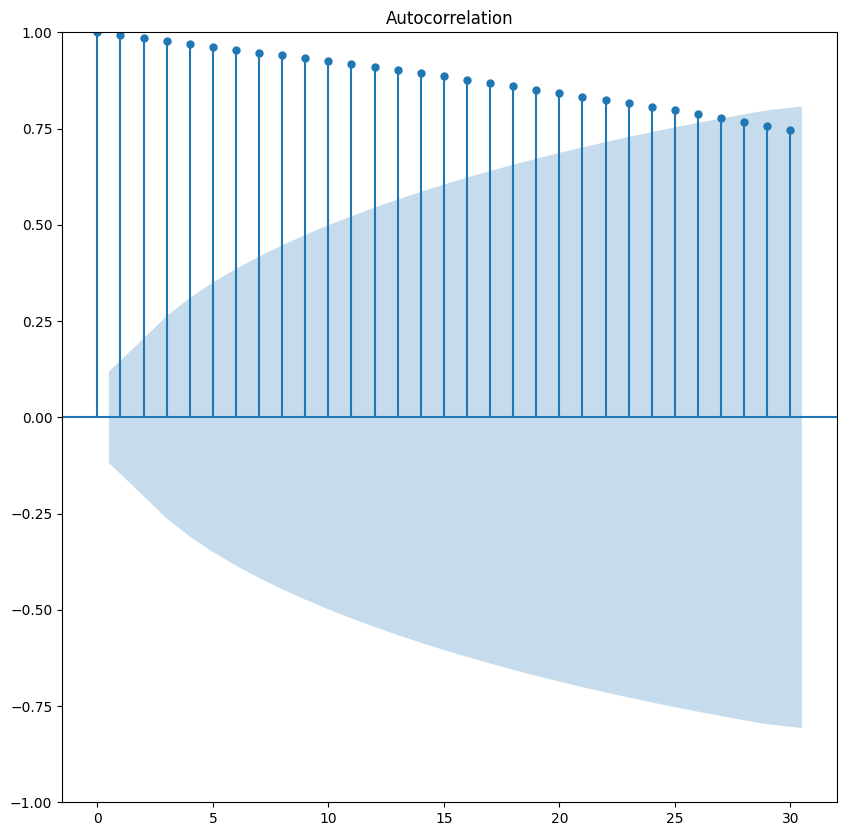

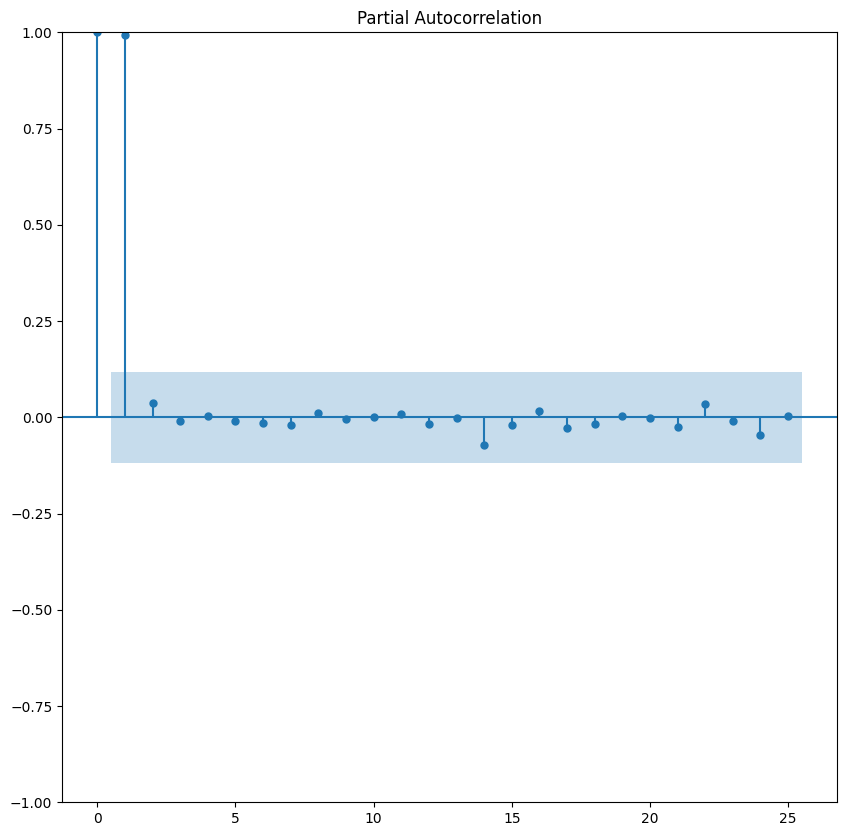

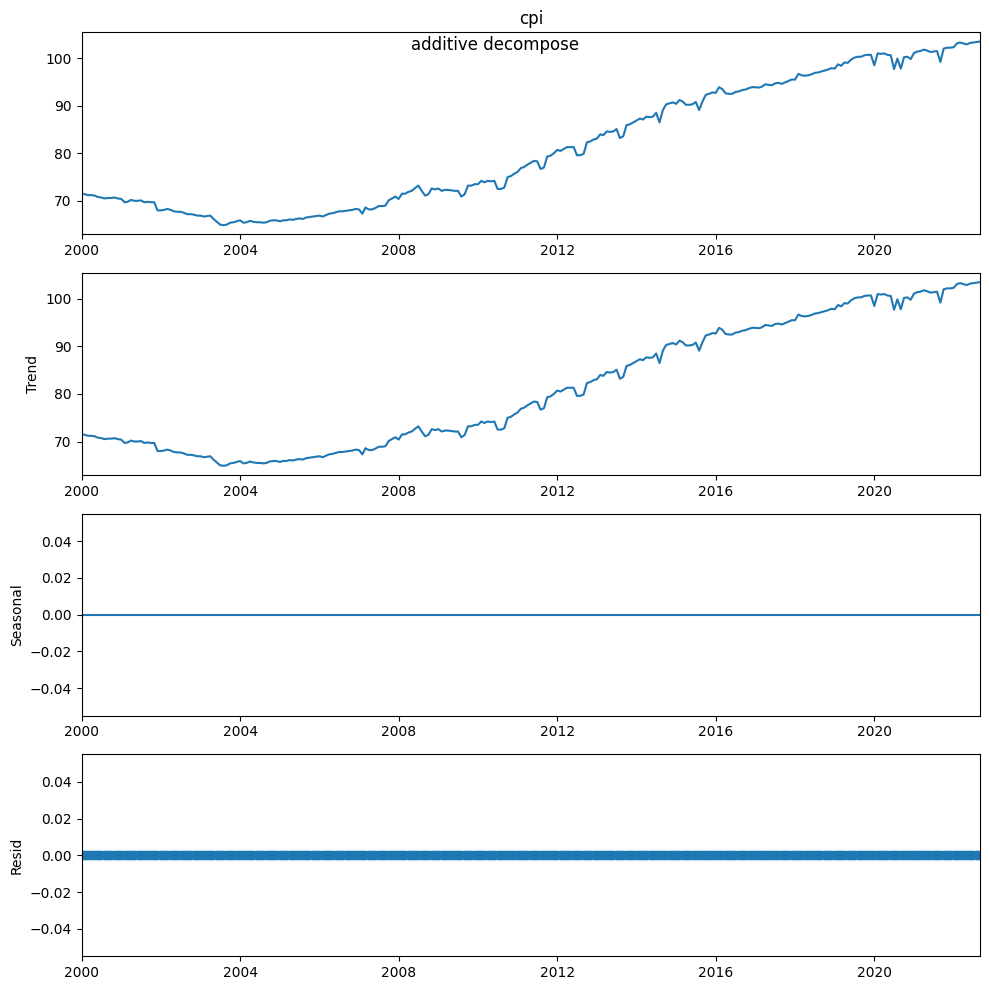

In [554]:
plotAll(df_clean, 'cpi', 'CPI Over Time', 'CPI', 2000, 2024, models='additive', periods=1)

In [555]:
#All stationarity result after log and differencing
# ['after_log','difference_1','difference_2','log_difference_1','log_difference_2']
allStationarity(df_clean,'cpi')

cpi : non-stationary
after_log : non-stationary
difference_1 : non-stationary
difference_2 : stationary
log_difference_1 : non-stationary
log_difference_2 : stationary


ADF statistic: 0.13010751944235635
p-value      : 0.9680575669229311
Critical values:
  1%,  -3.4560535712549925
Critical values:
  5%,  -2.8728527662442334
Critical values:
  10%,  -2.5727985212493754
It is non-stationary


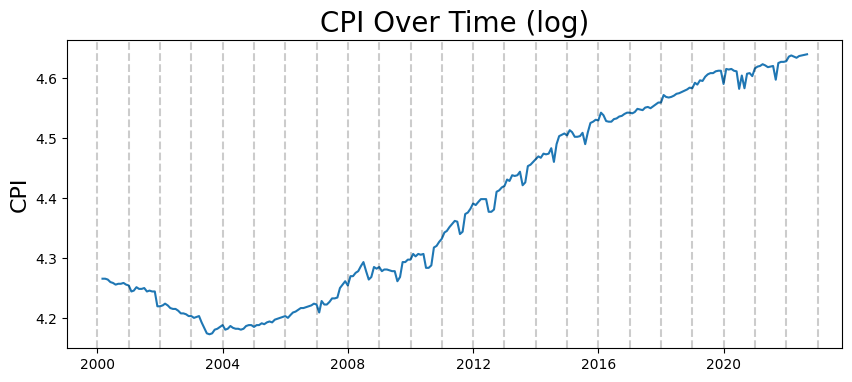

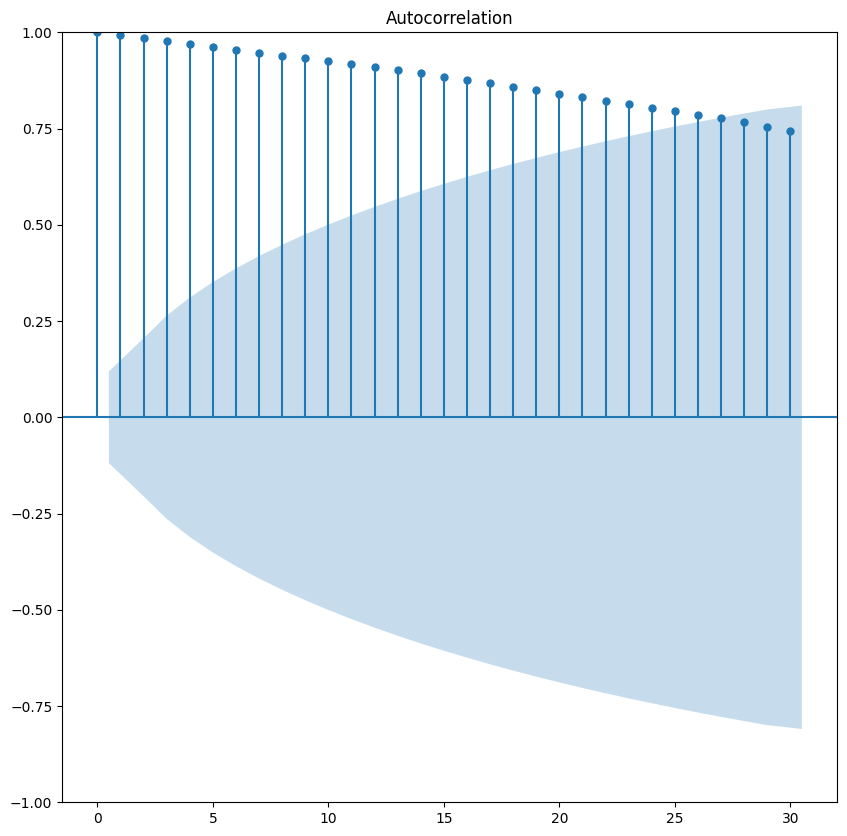

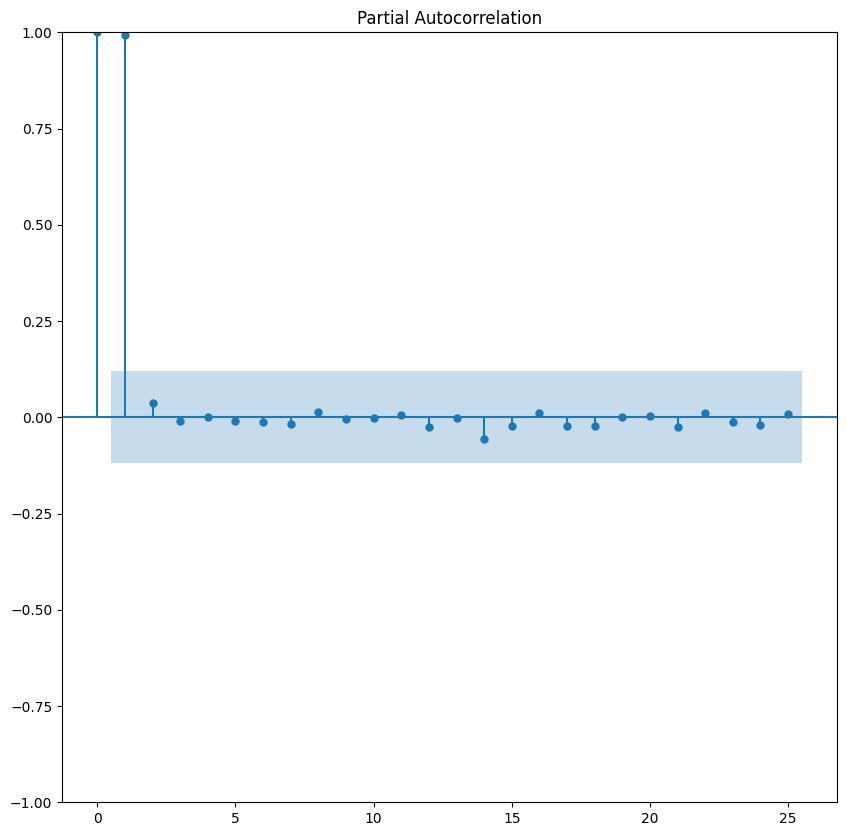

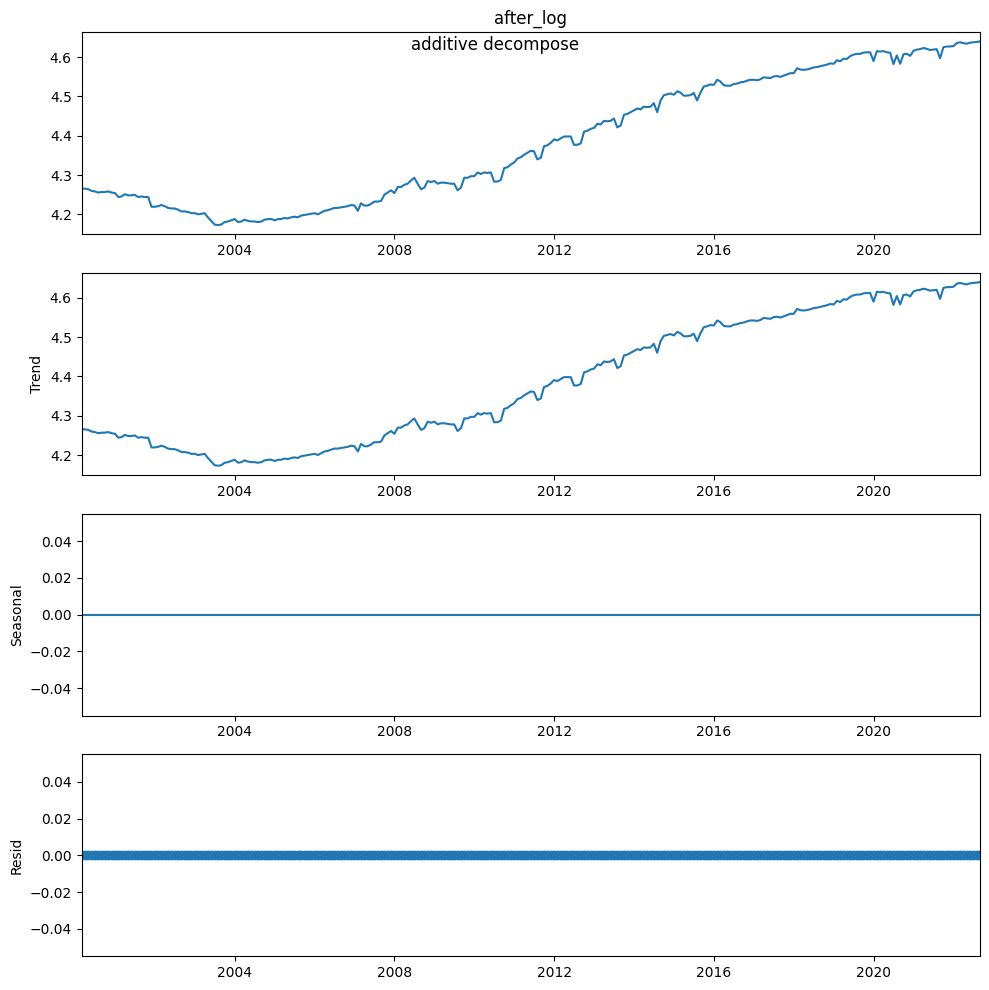

In [559]:
#Log Transformation
# plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1)
plotAll(df_clean, 'after_log', 'CPI Over Time (log)', 'CPI', 2000, 2024, models='additive', periods=1)

ADF statistic: -2.7410510235397596
p-value      : 0.06720002031374782
Critical values:
  1%,  -3.455952927706342
Critical values:
  5%,  -2.8728086526320302
Critical values:
  10%,  -2.572774990685656
It is non-stationary


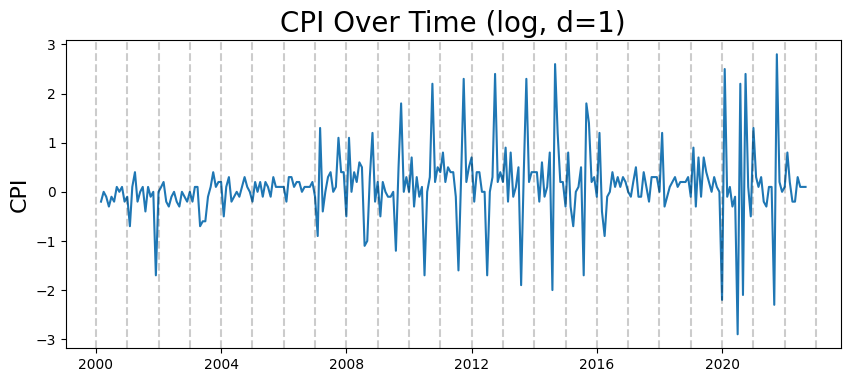

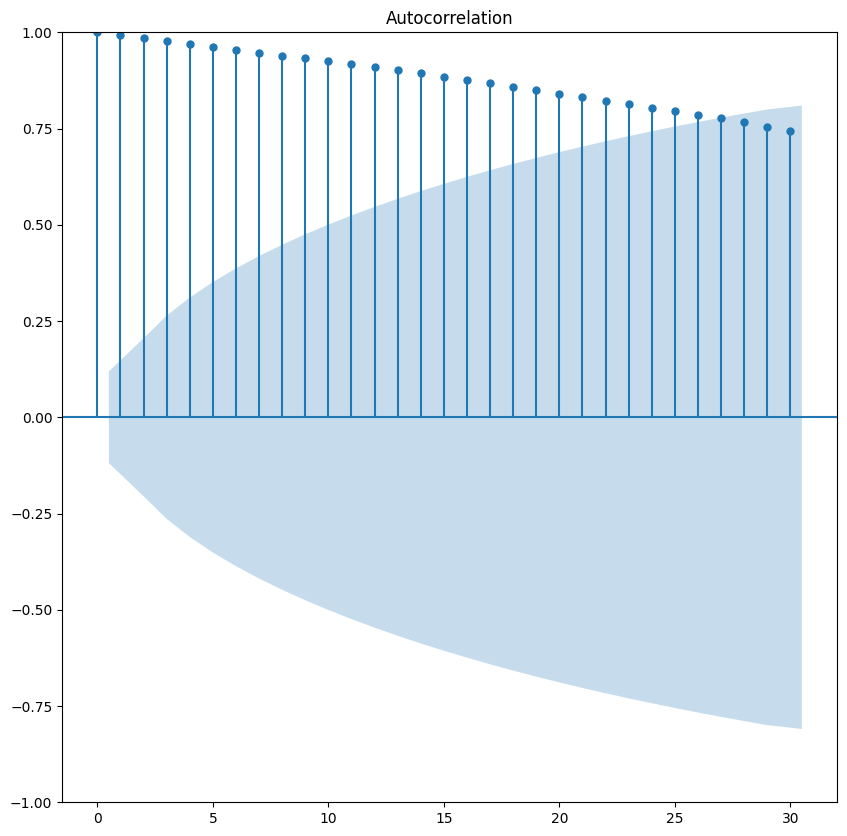

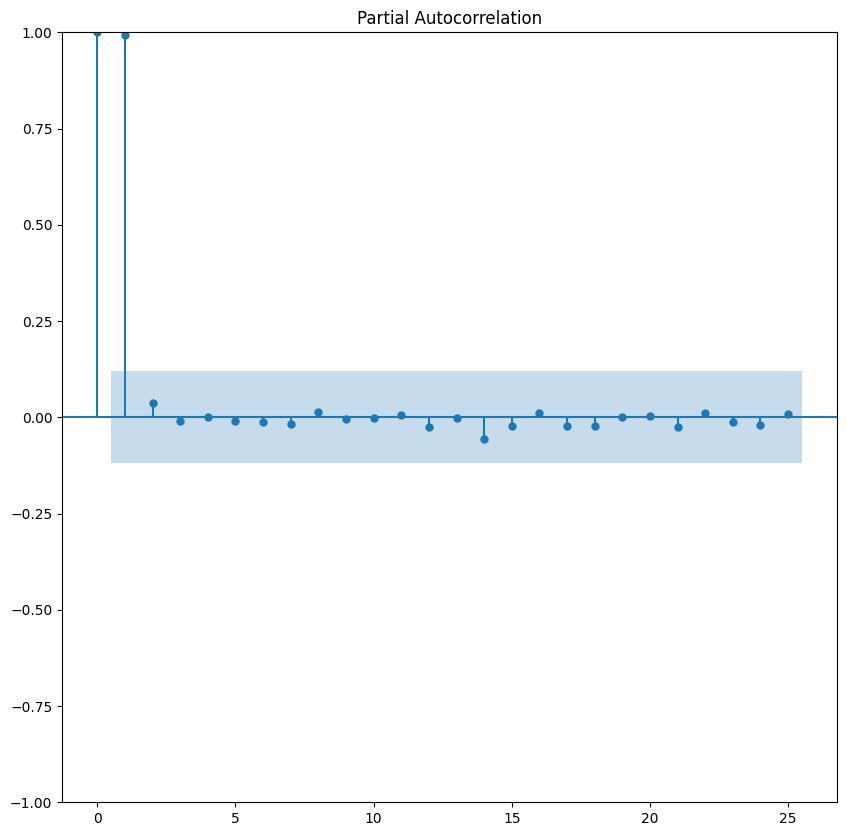

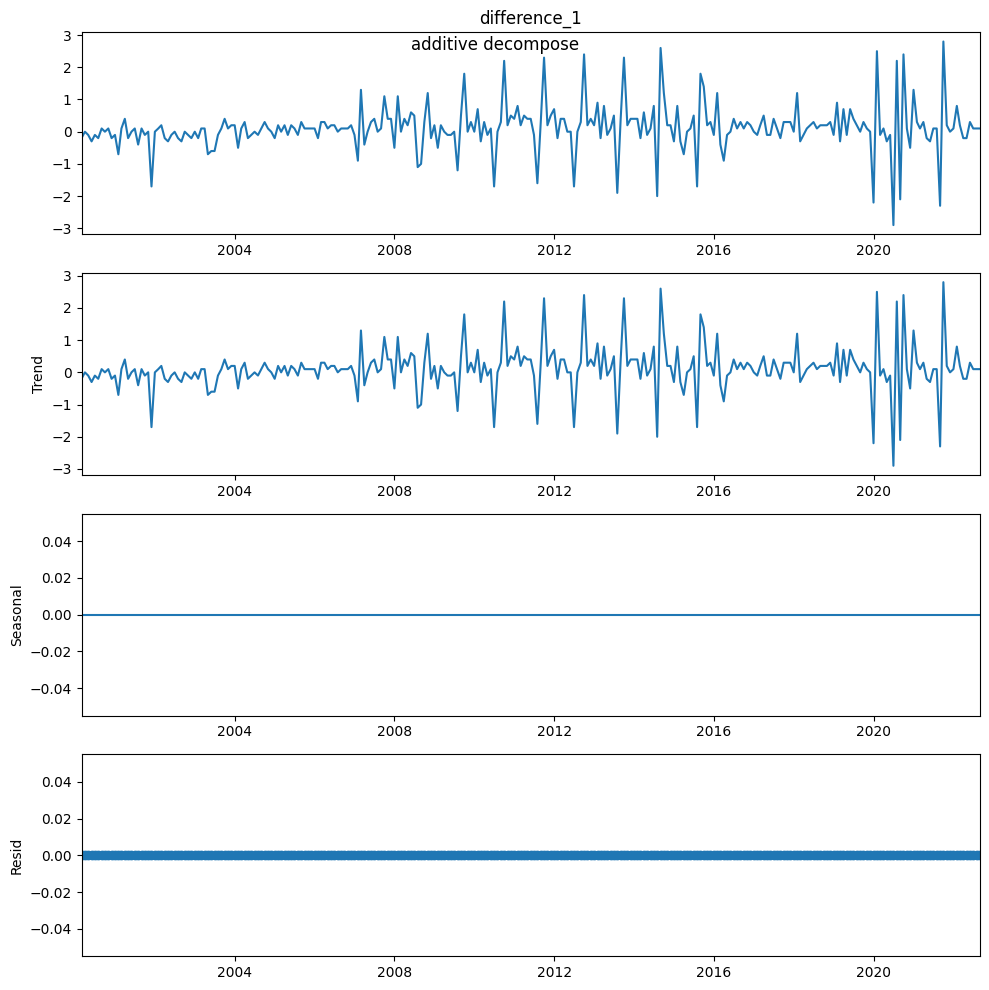

In [557]:
#First order differencing after log
plotAll(df_clean, 'difference_1', 'CPI Over Time (log, d=1)', 'CPI', 2000, 2024, models='additive', periods=1)

ADF statistic: -10.593527046864578
p-value      : 6.436376006164975e-19
Critical values:
  1%,  -3.455952927706342
Critical values:
  5%,  -2.8728086526320302
Critical values:
  10%,  -2.572774990685656
It is stationary


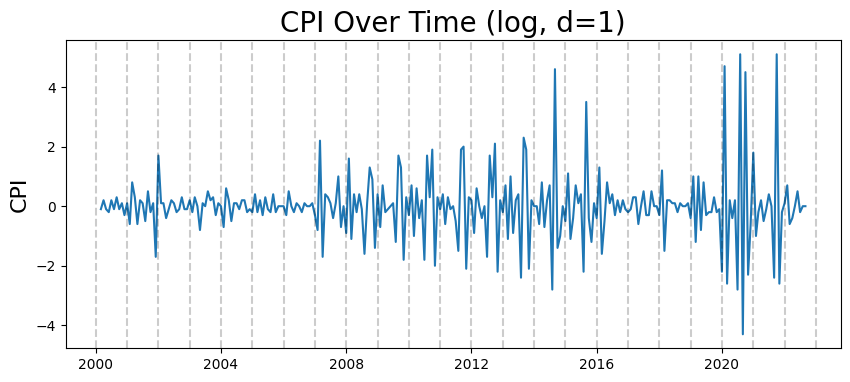

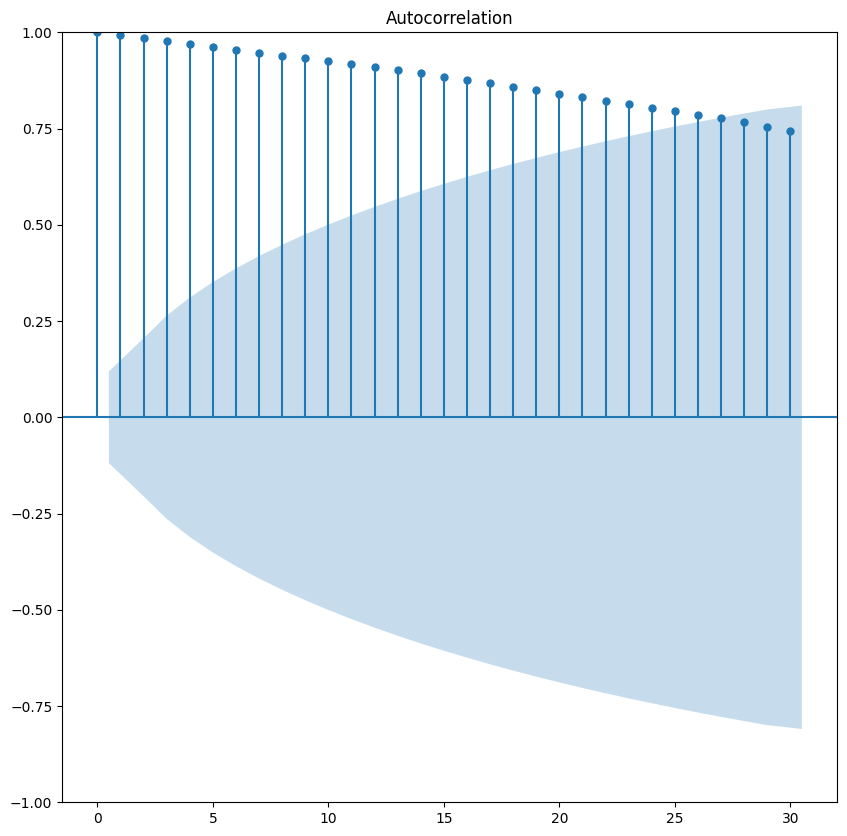

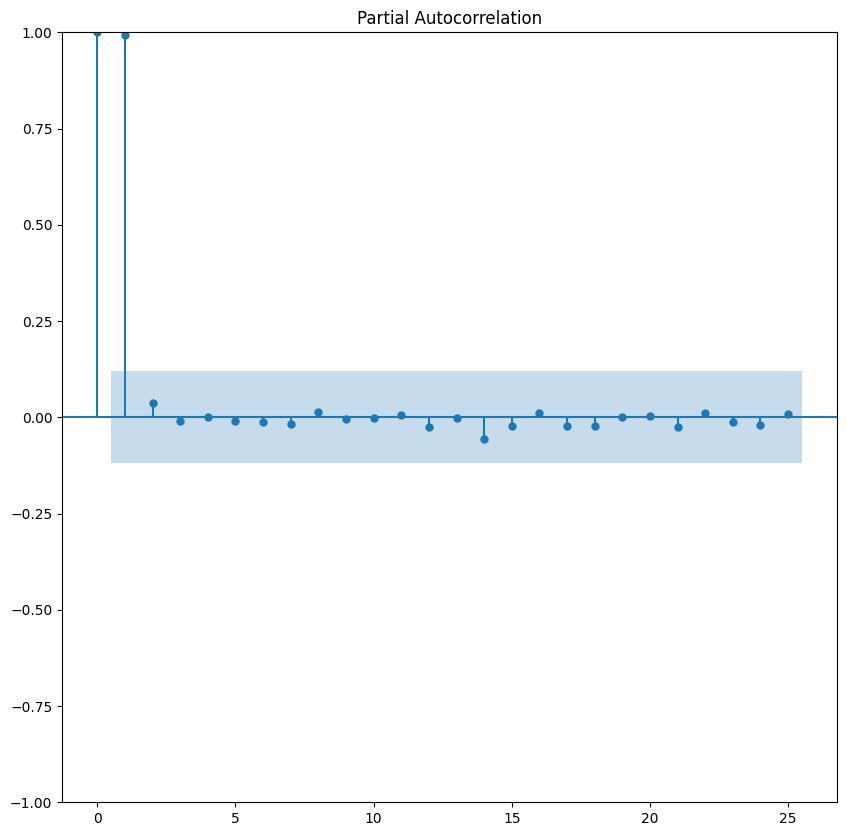

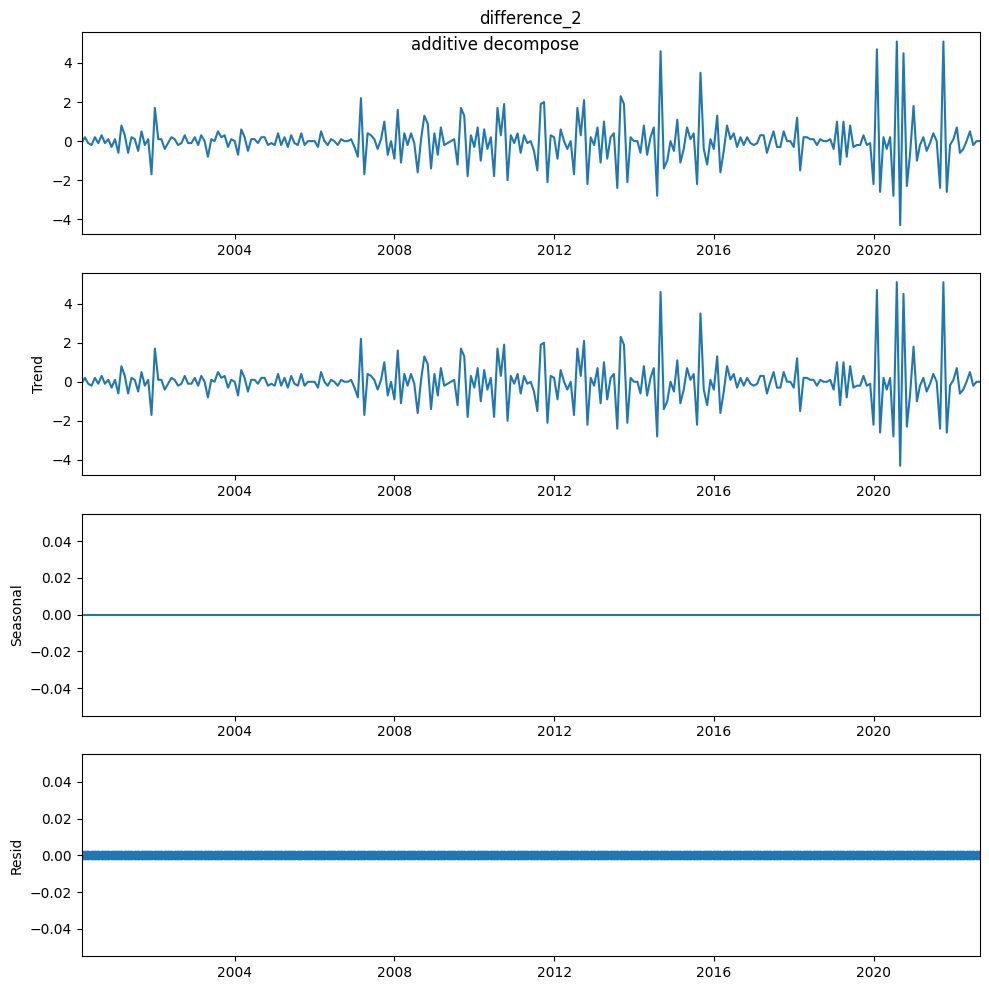

In [558]:
#Second order differencing after log
plotAll(df_clean, 'difference_2', 'CPI Over Time (log, d=1)', 'CPI', 2000, 2024, models='additive', periods=1)